In [59]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/plotting.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");
using LinearAlgebra
using Statistics

In [2]:
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.01
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [35]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=60,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);

  0.643069 seconds (529.39 k allocations: 4.510 GiB, 13.20% gc time)
  1.186222 seconds (18.53 k allocations: 1.347 GiB, 1.31% gc time)


In [4]:
# create the list of edges
# the following is incomplete but should be sufficient
epsilon = Int64.(zeros(4*contmod.Nx*contmod.Ny, 2))
l = 1

for k in 1:contmod.Nx*contmod.Ny
    if(contmod.isinside[k])
        epsilon[l,:] = [k k+contmod.Ny]
        epsilon[l+1,:] = [k k+1]
        l +=2
    end
end

for id in 1:size(contmod.n,1)
    k = (Int64(contmod.n[id, 2]) - 1) * contmod.Ny + Int64(contmod.n[id, 1])
    ny = contmod.n[id, 3]
    nx = contmod.n[id, 4]
    if(nx == 0)
        epsilon[l,:] = [k k+contmod.Ny]
        #epsilon[l+1,:] = [k k-contmod.Ny]
        #l +=2
        l +=1
    elseif(nx == -1)
        epsilon[l,:] = [k k+contmod.Ny]
        l +=1
    elseif(nx == 1)
        #epsilon[l,:] = [k k-contmod.Ny]
        #l +=1
    end
    if(ny == 0)
        epsilon[l,:] = [k k+1]
        #epsilon[l+1,:] = [k k-1]
        l +=1
    elseif(ny == -1)
        epsilon[l,:] = [k k+1]
        l +=1
    elseif(ny == 1)
        #epsilon[l,:] = [k k-1]
        #l +=1
    end
end

epsilon = epsilon[1:l-1,:]

epsilon_new = Int64.(zeros(size(epsilon)))
id = findall(contmod.isgrid)
n = length(id)
#id = findall(contmod.isborder)
#println(id)
for i = 1:length(id)
    id1 = (epsilon[:,1] .== id[i])
    id2 = (epsilon[:,2] .== id[i])
    epsilon_new[id1,1] .= i
    epsilon_new[id2,2] .= i
end

grid_coord = contmod.coord[contmod.isgrid, :];

In [5]:
# DONT DO THIS PLOT IF dx is smaller than ~0.05
if(dx >= 0.05)
    plot(aspect_ratio=:equal, legend=false)
    for k = 1:size(epsilon_new,1)
        if(epsilon_new[k,1] != 0 && epsilon_new[k,2] != 0)
            #println(coord[[epsilon_new[k,1] epsilon_new[k,2]],2],)
            plot!(vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],2]),
                vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],1]),color=:black)
        end
    end
    scatter!(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1])

    current()
end


In [6]:
N = size(epsilon_new,1)
id1 = [epsilon_new[:,1];epsilon_new[:,2]]
id2 = vec([1:N 1:N])
v = [-ones(N); ones(N)]
B = sparse(id1, id2, v)
L = B*B'
Lfull = Array{Float64,2}(L)
res = eigen(Lfull);

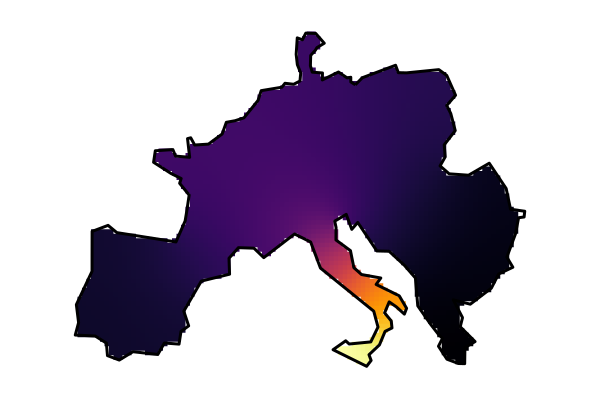

In [7]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(res.vectors[:,3])
hm_plot(contmod, temp; borders=[border])

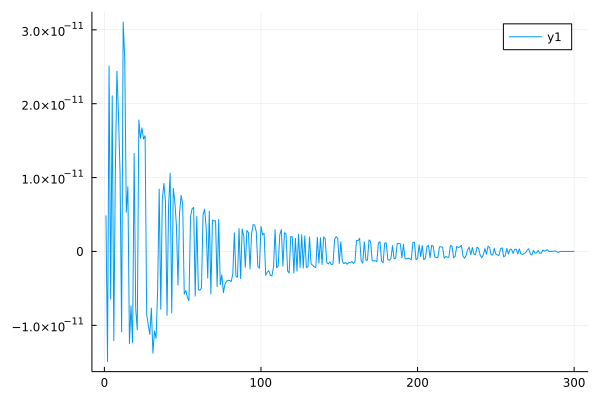

In [8]:
# perform Lanczos Algorithm

v = rand(n,1)
v = v .- mean(v)
v = v / norm(v)

w =  L * v
alpha = dot(w, v)
w = w - alpha * v

V = v
as = alpha
bs = []

Ncut = 300 # don't go to high or the eigenvectors you get do not satisfy sum(v)=0 any more

for i=2:Ncut
    beta = norm(w)
    if(beta > 1E-6)
        v = w / beta
    else
        println("CAWABUNGA")
        v = rand(n, 1)
        for j=1:i-1
            v -= dot(v, V[:,j]) * V[:,j]
        end
        v  /= norm(v)
    end

    w = L * v
    alpha = dot(w, v)
    w = w - alpha * v - beta * V[:,i-1]
    bs = [bs; beta]
    as = [as alpha]
    V = [V v]
end


T = zeros(Ncut, Ncut)
for i=1:Ncut
    T[i,i] = as[i]
end
for i=1:Ncut-1
    T[i, i+1] = bs[i]
    T[i+1, i] = bs[i]
end


res2 = eigen(T)
VV = V * res2.vectors;
s = zeros(Ncut)
for i=1:Ncut
    s[i] = sum(VV[:,i])
end
plot(s)

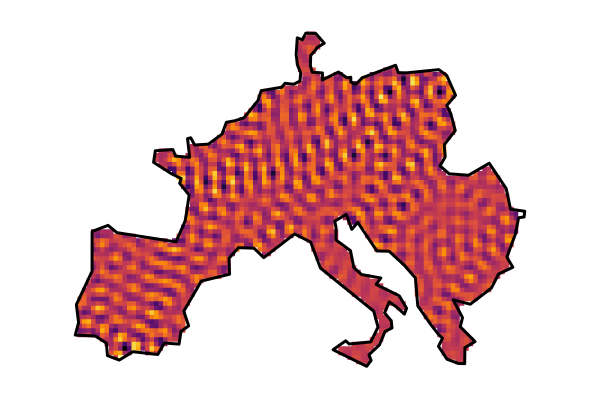

In [9]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(VV[:,110])
hm_plot(contmod, temp; borders=[border])

In [10]:
# project the quantities over the modes

mred = ones(size(contmod.m))
dred = zeros(size(contmod.d))
pred = zeros(size(contmod.p))
bxred = zeros(size(contmod.bx))
byred = zeros(size(contmod.by))
mred[contmod.isgrid] .= mean(contmod.m[contmod.isgrid])

dred[contmod.isgrid] .= mean(contmod.d[contmod.isgrid])
pred .= mean(contmod.p)
bxred[contmod.isgrid] .= mean(contmod.bx[contmod.isgrid])
byred[contmod.isgrid] .= mean(contmod.by[contmod.isgrid])

for i = 1:80
    mred[contmod.isgrid] += dot(contmod.m[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    dred[contmod.isgrid] += dot(contmod.d[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    bxred[contmod.isgrid] += dot(contmod.bx[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    byred[contmod.isgrid] += dot(contmod.by[contmod.isgrid], vec(VV[:,i])) * vec(VV[:,i])
    pred += dot(contmod.p, vec(VV[:,i])) * vec(VV[:,i])
end

-1.916312612593174e-6


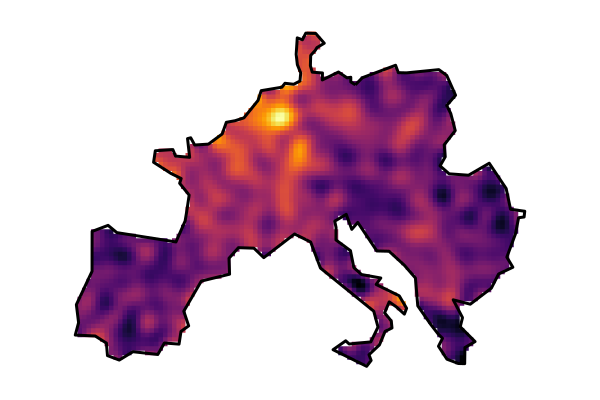

In [11]:
println(sum(pred))
sum(contmod.p)
hm_plot(contmod, mred; borders=[border])

In [12]:
# compute or load grid parameters
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=60,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);
contmod2.m = mred
contmod2.d = dred
contmod2.p = pred
contmod2.bx = bxred
contmod2.by = byred

contmod2.bx = max.(contmod2.bx, mean(contmod2.bx[contmod.isgrid])) # the graph that I created is offset for bs
contmod2.by = max.(contmod2.by, mean(contmod2.by[contmod.isgrid])); #

  0.703795 seconds (529.39 k allocations: 4.510 GiB, 11.57% gc time)
  1.237406 seconds (18.53 k allocations: 1.347 GiB, 1.70% gc time)


In [13]:
# get stable solution
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 3.5870338639942823e-6]
[20000.0 1.4146910530671297e-6]
[30000.0 1.0883993471905162e-6]
[40000.0 1.0403268929370935e-6]
[50000.0 1.0333131375828142e-6]
[60000.0 1.032291702188215e-6]
[70000.0 1.0321429922133252e-6]
[80000.0 1.0321213427116893e-6]
[90000.0 1.0321181909966892e-6]
[100000.0 1.0321177321970243e-6]
[110000.0 1.0321176653338426e-6]
[120000.0 1.0321176556749023e-6]
[130000.0 1.0321176547312128e-6]
[140000.0 1.0321176540373234e-6]
[150000.0 1.032117654065079e-6]
[160000.0 1.0321176542316124e-6]
[170000.0 1.032117654259368e-6]
[180000.0 1.0321176540095678e-6]
[190000.0 1.0321176539818122e-6]
[200000.0 1.0321176542871235e-6]
[210000.0 1.0321176542316124e-6]
[220000.0 1.03211765399569e-6]
[230000.0 1.0321176540373234e-6]
[240000.0 1.032117654065079e-6]
[250000.0 1.0321176542038568e-6]
  7.499933 seconds (3.57 M allocations: 21.707 GiB, 4.91% gc time, 6.10% compilation time)


In [46]:
ts, thetas, omegas = perform_dyn_sim(contmod2, interval=2,
    Ndt=2000, dt=0.01, method="crank-nicolson");

Total time: 20.0
NIter: 2 Avg. Omega: 0.005265773387467928
NIter: 4 Avg. Omega: 0.002607657485646575
NIter: 6 Avg. Omega: 0.0039039050998679868
NIter: 8 Avg. Omega: 0.015803086972125114
NIter: 10 Avg. Omega: 0.02964188238298243
NIter: 12 Avg. Omega: 0.03356324414516766
NIter: 14 Avg. Omega: 0.027510426485669388
NIter: 16 Avg. Omega: 0.021947923162173442
NIter: 18 Avg. Omega: 0.018292020643587648
NIter: 20 Avg. Omega: 0.009606715773349032
NIter: 22 Avg. Omega: -0.0002277754208867472
NIter: 24 Avg. Omega: -0.006716882851303371
NIter: 26 Avg. Omega: -0.009596012050512371
NIter: 28 Avg. Omega: -0.010105214071506158
NIter: 30 Avg. Omega: -0.012537125273169301
NIter: 32 Avg. Omega: -0.023682478081625706
NIter: 34 Avg. Omega: -0.03151366862154091
NIter: 36 Avg. Omega: -0.028724251008219372
NIter: 38 Avg. Omega: -0.02516602910427818
NIter: 40 Avg. Omega: -0.02083185498726554
NIter: 42 Avg. Omega: -0.012651129086235148
NIter: 44 Avg. Omega: -0.00798438198744735
NIter: 46 Avg. Omega: -0.01321080

NIter: 376 Avg. Omega: -0.12600593789519532
NIter: 378 Avg. Omega: -0.12157538066724949
NIter: 380 Avg. Omega: -0.11474214156646623
NIter: 382 Avg. Omega: -0.10674819247497752
NIter: 384 Avg. Omega: -0.10260042408025918
NIter: 386 Avg. Omega: -0.10415712846531998
NIter: 388 Avg. Omega: -0.10770611440200664
NIter: 390 Avg. Omega: -0.10967863965370504
NIter: 392 Avg. Omega: -0.10861094563980533
NIter: 394 Avg. Omega: -0.10851375265941668
NIter: 396 Avg. Omega: -0.10948865665983183
NIter: 398 Avg. Omega: -0.11313202848240954
NIter: 400 Avg. Omega: -0.11821986271155216
NIter: 402 Avg. Omega: -0.12093074489245957
NIter: 404 Avg. Omega: -0.1196205898541606
NIter: 406 Avg. Omega: -0.11718876311726098
NIter: 408 Avg. Omega: -0.11134493889207513
NIter: 410 Avg. Omega: -0.10297275128793114
NIter: 412 Avg. Omega: -0.09691923725819074
NIter: 414 Avg. Omega: -0.09637850018321993
NIter: 416 Avg. Omega: -0.09769050480269545
NIter: 418 Avg. Omega: -0.09765708183023555
NIter: 420 Avg. Omega: -0.0967219

NIter: 752 Avg. Omega: -0.15172250401215515
NIter: 754 Avg. Omega: -0.15563589736884395
NIter: 756 Avg. Omega: -0.15495293028960724
NIter: 758 Avg. Omega: -0.15067993505807994
NIter: 760 Avg. Omega: -0.14688656091887067
NIter: 762 Avg. Omega: -0.14694598591107433
NIter: 764 Avg. Omega: -0.14887127509558362
NIter: 766 Avg. Omega: -0.15057398383509843
NIter: 768 Avg. Omega: -0.1537908624908014
NIter: 770 Avg. Omega: -0.15454202410993004
NIter: 772 Avg. Omega: -0.1512928454871938
NIter: 774 Avg. Omega: -0.14646296786966945
NIter: 776 Avg. Omega: -0.14319810584685275
NIter: 778 Avg. Omega: -0.1427410207573667
NIter: 780 Avg. Omega: -0.14497880898639406
NIter: 782 Avg. Omega: -0.14819302646965954
NIter: 784 Avg. Omega: -0.150361226557266
NIter: 786 Avg. Omega: -0.15045866110807687
NIter: 788 Avg. Omega: -0.14941020597412738
NIter: 790 Avg. Omega: -0.14729250708471825
NIter: 792 Avg. Omega: -0.14491320452147416
NIter: 794 Avg. Omega: -0.14361819785096244
NIter: 796 Avg. Omega: -0.14663002849

NIter: 1124 Avg. Omega: -0.16618900831859842
NIter: 1126 Avg. Omega: -0.16630070963779986
NIter: 1128 Avg. Omega: -0.1660531288354224
NIter: 1130 Avg. Omega: -0.16586144769216987
NIter: 1132 Avg. Omega: -0.1655330231659632
NIter: 1134 Avg. Omega: -0.16585675788728652
NIter: 1136 Avg. Omega: -0.16602292321086648
NIter: 1138 Avg. Omega: -0.16508850576096035
NIter: 1140 Avg. Omega: -0.16430858023714073
NIter: 1142 Avg. Omega: -0.16419026067980125
NIter: 1144 Avg. Omega: -0.16406465237275594
NIter: 1146 Avg. Omega: -0.16392605537270458
NIter: 1148 Avg. Omega: -0.16445934588108996
NIter: 1150 Avg. Omega: -0.16563406025670507
NIter: 1152 Avg. Omega: -0.16616286331201705
NIter: 1154 Avg. Omega: -0.1645967405653008
NIter: 1156 Avg. Omega: -0.16156395136764978
NIter: 1158 Avg. Omega: -0.1595679576090871
NIter: 1160 Avg. Omega: -0.15849984893733468
NIter: 1162 Avg. Omega: -0.1592141299433782
NIter: 1164 Avg. Omega: -0.1617525117775677
NIter: 1166 Avg. Omega: -0.16411814834288904
NIter: 1168 Avg.

NIter: 1494 Avg. Omega: -0.165034340218873
NIter: 1496 Avg. Omega: -0.16515577290376582
NIter: 1498 Avg. Omega: -0.16576595350812012
NIter: 1500 Avg. Omega: -0.16641579161596803
NIter: 1502 Avg. Omega: -0.16731754306642385
NIter: 1504 Avg. Omega: -0.1678371574042368
NIter: 1506 Avg. Omega: -0.1677070109774979
NIter: 1508 Avg. Omega: -0.16714223046070537
NIter: 1510 Avg. Omega: -0.16621242468855663
NIter: 1512 Avg. Omega: -0.16540255022998174
NIter: 1514 Avg. Omega: -0.1655074080721951
NIter: 1516 Avg. Omega: -0.16560854467662825
NIter: 1518 Avg. Omega: -0.1658003179733391
NIter: 1520 Avg. Omega: -0.16596287859895564
NIter: 1522 Avg. Omega: -0.16542776573142726
NIter: 1524 Avg. Omega: -0.16440236269595063
NIter: 1526 Avg. Omega: -0.16405970522125832
NIter: 1528 Avg. Omega: -0.1643457363561112
NIter: 1530 Avg. Omega: -0.1645880607833091
NIter: 1532 Avg. Omega: -0.16533230239327928
NIter: 1534 Avg. Omega: -0.16625268252529532
NIter: 1536 Avg. Omega: -0.16656404835677296
NIter: 1538 Avg. O

NIter: 1862 Avg. Omega: -0.1666893499729696
NIter: 1864 Avg. Omega: -0.16693038160693296
NIter: 1866 Avg. Omega: -0.16733497031354722
NIter: 1868 Avg. Omega: -0.16798001764938195
NIter: 1870 Avg. Omega: -0.16854240169315304
NIter: 1872 Avg. Omega: -0.16824149073156328
NIter: 1874 Avg. Omega: -0.1677716025744482
NIter: 1876 Avg. Omega: -0.1676582162396845
NIter: 1878 Avg. Omega: -0.16734621956439663
NIter: 1880 Avg. Omega: -0.16694375916308707
NIter: 1882 Avg. Omega: -0.16673368177238548
NIter: 1884 Avg. Omega: -0.1664875421912318
NIter: 1886 Avg. Omega: -0.1660910062225759
NIter: 1888 Avg. Omega: -0.16599183870397946
NIter: 1890 Avg. Omega: -0.1661114906585059
NIter: 1892 Avg. Omega: -0.1664478175794375
NIter: 1894 Avg. Omega: -0.16684965812410896
NIter: 1896 Avg. Omega: -0.1673033148651843
NIter: 1898 Avg. Omega: -0.16770341728520416
NIter: 1900 Avg. Omega: -0.16787524015290156
NIter: 1902 Avg. Omega: -0.16802202464182175
NIter: 1904 Avg. Omega: -0.16820946256543476
NIter: 1906 Avg. O

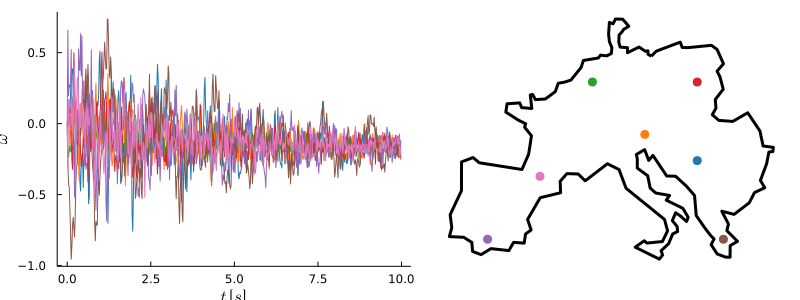

In [50]:
# check what's going on
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
#c = [-1500.0 -1000.0] / scale_factor
time_plot(contmod, ts, omegas, c, borders = [border], tstart = 0.0, tend = 10.0)

In [25]:
# reset the initial angles to their last simulation values
contmod2.th[contmod2.isgrid] = thetas[:,end];

In [26]:
# when stabilize add the disturbance
add_local_disturbance!(contmod2, [-0.35; 0.24], -10.0, 0.02, dx);

In [36]:
# now with the full model for comparison
# get stable solution
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 4.588640473132677e-6]
[20000.0 2.9630576478534287e-6]
[30000.0 2.724420634148128e-6]
[40000.0 2.6892578538217915e-6]
[50000.0 2.68412669862661e-6]
[60000.0 2.6833794057601335e-6]
[70000.0 2.683270607511945e-6]
[80000.0 2.683254768404142e-6]
[90000.0 2.683252462637453e-6]
[100000.0 2.683252126683966e-6]
[110000.0 2.6832520778063973e-6]
[120000.0 2.68325207070097e-6]
[130000.0 2.6832520697572804e-6]
[140000.0 2.683252069923814e-6]
[150000.0 2.683252070423414e-6]
[160000.0 2.6832520697572804e-6]
[170000.0 2.683252069646258e-6]
[180000.0 2.683252069646258e-6]
[190000.0 2.683252069590747e-6]
[200000.0 2.683252069979325e-6]
[210000.0 2.6832520695352358e-6]
[220000.0 2.6832520693687023e-6]
[230000.0 2.6832520695352358e-6]
[240000.0 2.6832520700903473e-6]
[250000.0 2.6832520702013696e-6]
  6.711621 seconds (2.26 M allocations: 21.633 GiB, 4.03% gc time)


In [58]:
add_local_disturbance!(contmod, [-0.35; 0.24], 10.0, 0.02, dx);
println(sum(contmod.p)*dx^2)

-2.3283064365386964e-14


In [55]:
ts, thetas, omegas = perform_dyn_sim(contmod, interval=2,
    Ndt=2000, dt=0.01, method="be");

Total time: 20.0
NIter: 2 Avg. Omega: -0.09024864137185443
NIter: 4 Avg. Omega: -0.1276304872108235
NIter: 6 Avg. Omega: -0.12481017898780113
NIter: 8 Avg. Omega: -0.10434277500022159
NIter: 10 Avg. Omega: -0.08192060928527764
NIter: 12 Avg. Omega: -0.06153622811823219
NIter: 14 Avg. Omega: -0.04147218839706138
NIter: 16 Avg. Omega: -0.02266358991645987
NIter: 18 Avg. Omega: -0.012920914688618751
NIter: 20 Avg. Omega: -0.019991510806108188
NIter: 22 Avg. Omega: -0.03578598190137961
NIter: 24 Avg. Omega: -0.045493403168457514
NIter: 26 Avg. Omega: -0.04876209586826104
NIter: 28 Avg. Omega: -0.051887887318603075
NIter: 30 Avg. Omega: -0.057647832233420036
NIter: 32 Avg. Omega: -0.06119137301477892
NIter: 34 Avg. Omega: -0.06185760877625671
NIter: 36 Avg. Omega: -0.05990141831983663
NIter: 38 Avg. Omega: -0.05611739735785199
NIter: 40 Avg. Omega: -0.06125906298669294
NIter: 42 Avg. Omega: -0.07804265243794957
NIter: 44 Avg. Omega: -0.09555703523720072
NIter: 46 Avg. Omega: -0.102824401445

NIter: 378 Avg. Omega: -0.12744497817592346
NIter: 380 Avg. Omega: -0.12445733477209857
NIter: 382 Avg. Omega: -0.1263171662909171
NIter: 384 Avg. Omega: -0.1328321270300209
NIter: 386 Avg. Omega: -0.14070834066815813
NIter: 388 Avg. Omega: -0.14907153122759137
NIter: 390 Avg. Omega: -0.15707373904195315
NIter: 392 Avg. Omega: -0.16144904673046437
NIter: 394 Avg. Omega: -0.1602569462785525
NIter: 396 Avg. Omega: -0.15573436623961548
NIter: 398 Avg. Omega: -0.1492818244948741
NIter: 400 Avg. Omega: -0.14118638839443243
NIter: 402 Avg. Omega: -0.13427673630559508
NIter: 404 Avg. Omega: -0.13387605953089973
NIter: 406 Avg. Omega: -0.13895422676598196
NIter: 408 Avg. Omega: -0.1456315826446818
NIter: 410 Avg. Omega: -0.15099244285824182
NIter: 412 Avg. Omega: -0.15376195310095153
NIter: 414 Avg. Omega: -0.1541891760868219
NIter: 416 Avg. Omega: -0.15517838958211427
NIter: 418 Avg. Omega: -0.1572828387809727
NIter: 420 Avg. Omega: -0.1561089643432401
NIter: 422 Avg. Omega: -0.14981304411595

LoadError: InterruptException:

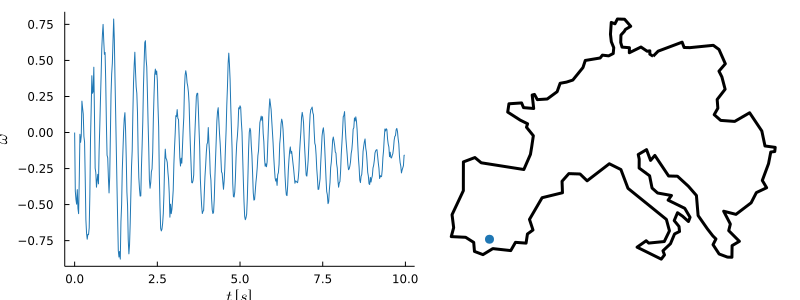

In [44]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
c = [-1500.0 -1000;] / scale_factor
time_plot(contmod, ts, omegas, c, borders = [border], tstart = 0.0, tend = 10.0)

In [33]:
# reset the initial angles to their last simulation values
contmod.th[contmod.isgrid] = thetas[:,end];

-19.99999999999999